# Variational Gradient Matching for Dynamical Systems: Lorenz Attractor
                        Fast Parameter Identification for Nonlinear Dynamical Systems
                        
<img src="docs/logo.png">

#### Authors: Nico S. Gorbach and Stefan Bauer


#### Contents

Instructional code for the NIPS (2018) paper [Scalable Variational Inference for Dynamical Systems](https://papers.nips.cc/paper/7066-scalable-variational-inference-for-dynamical-systems.pdf) by Nico S. Gorbach, Stefan Bauer and Joachim M. Buhmann. Please cite our paper if you use our program for a further publication. The derivations in this document are also given in this [doctoral thesis](https://www.research-collection.ethz.ch/handle/20.500.11850/261734) as well as in parts of [Wenk et al. (2018)](https://arxiv.org/pdf/1804.04378.pdf).
Example dynamical system used in this code: Lorenz attractor system with the y-dimension unobserved. The ODE parameters are also unobserved.

## Import VGM Modules

In [1]:
from Lorenz_attractor_declarations import *
from import_odes import *
from simulate_state_dynamics import *
from GP_regression import *
from rewrite_odes_as_local_linear_combinations import *
from proxies_for_ode_parameters_and_states import *

## User Input

### Simulation Settings

##### True ODE parameters
Input a row vector of real numbers of size $1$ x $3$:

In [2]:
simulation.ode_param = [10.0,28.0,8.0/3.0]
# ODE parameters shown on the Wikipedia page: https://en.wikipedia.org/wiki/Lorenz_system

##### Observed states
Input 1, 2 or 3 symbolic variables from the set $(x,y,z)$:

In [3]:
simulation.observed_states = sym.symbols(['x','y','z'])

##### Final time for simulation
Input a positive real number:

In [4]:
simulation.final_time_point = 20.0

##### Observation noise
Input a positive real number:

In [5]:
simulation.obs_variance = 0.1

##### Time interval between observations
Input a positive real number:

In [6]:
simulation.interval_between_observations = 0.1

### Estimation Settings

##### Kernel parameters $\boldsymbol\phi$
Input a row vector of positive real numbers of size 1 x 2:

In [7]:
kernel.param = [10,0.2]

##### Time points used to estimate the state trajectories
Input a row vector of positive real numbers in ascending order:

In [8]:
time_points.for_estimation = np.arange(0,20.0,0.1)

## Import Lorenz Attractor ODEs

The Lorenz attractor ODEs are given by:

\begin{align}
  \dot{x} &= \sigma ~ (y-x)\\
  \dot{y} &= -x ~ z + \rho ~ x -y \\
  \dot{z} &= x ~ y - \alpha ~ z 
\end{align}

In [9]:
odes = import_odes(symbols,odes_path)
state_couplings = find_state_couplings_in_odes(odes,symbols)

## Simulate Trajectories

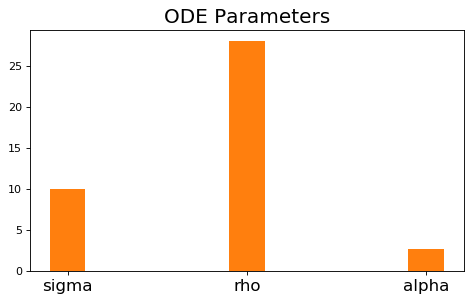

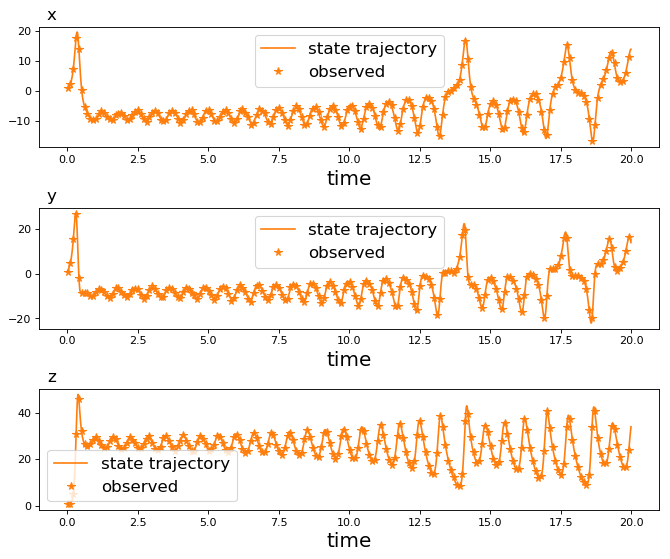

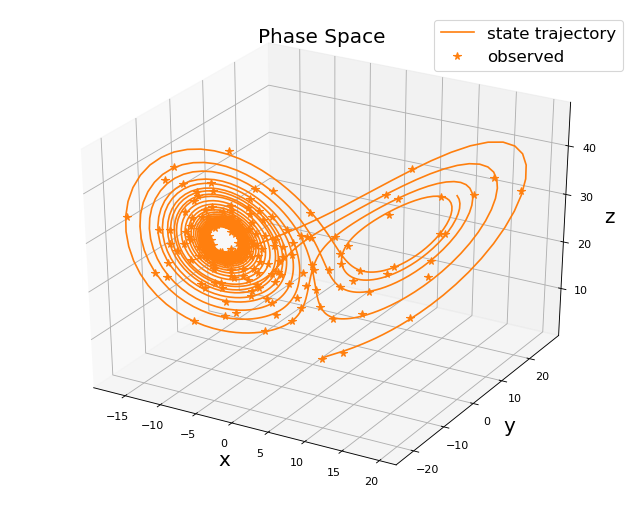

In [10]:
simulation.state, simulation.observations, time_points.observed, obs_to_state_relations = simulate_state_dynamics(simulation,time_points,symbols.state,symbols.param,odes,1)

## Prior on States and State Derivatives
Gradient matching with Gaussian processes assumes a joint Gaussian process prior on states and their derivatives:

\begin{align}
\begin{bmatrix}
\mathbf{X} \\ \dot{\mathbf{X}}
\end{bmatrix} 
 \sim \mathcal{N} \left(\begin{bmatrix}
\mathbf{X} \\ \dot{\mathbf{X}}
\end{bmatrix} ; 
 \begin{bmatrix}
 \mathbf{0} \\ \mathbf{0}
 \end{bmatrix},
 \begin{bmatrix}
 \mathbf{C}_{\boldsymbol\phi} & \mathbf{C}_{\boldsymbol\phi}' \\
 '\mathbf{C}_{\boldsymbol\phi} & \mathbf{C}_{\boldsymbol\phi}'' 
 \end{bmatrix}
 \right),
 \label{eqn:joint_state_and_derivatives}
\end{align}

with:

\begin{align}
\mathrm{cov}(x_k(t), x_k(t)) &= C_{\boldsymbol\phi_k}(t,t') \nonumber \\
\mathrm{cov}(\dot{x}_k(t), x_k(t)) &= \frac{\partial C_{\boldsymbol\phi_k}(t,t') }{\partial t} =: C_{\boldsymbol\phi_k}'(t,t') \nonumber \\
\mathrm{cov}(x_k(t), \dot{x}_k(t)) &= \frac{\partial C_{\boldsymbol\phi_k}(t,t') }{\partial t'} =: {'C_{\boldsymbol\phi_k}(t,t')} \nonumber \\
\mathrm{cov}(\dot{x}_k(t), \dot{x}_k(t)) &= \frac{\partial C_{\boldsymbol\phi_k}(t,t') }{\partial t \partial t'} =: C_{\boldsymbol\phi_k}''(t,t').
\end{align}

## Matching Gradients

Given the joint distribution over states and their derivatives \ref{eqn:joint_state_and_derivatives} as well as the ODEs \ref{eqn:ODE}, we therefore have two expressions for the state derivatives:

\begin{align}
&\dot{\mathbf{X}} = \mathbf{F} + \boldsymbol\epsilon_1, &&\boldsymbol\epsilon_1 \sim \mathcal{N}\left(\boldsymbol\epsilon_1;\mathbf{0}, \mathbf{I}\gamma \right) \nonumber \\
&\dot{\mathbf{X}} = {'\mathbf{C}_{\boldsymbol\phi}} \mathbf{C}_{\boldsymbol\phi}^{-1} ~\mathbf{X} + \boldsymbol\epsilon_2, &&\boldsymbol\epsilon_2 \sim \mathcal{N}\left(\boldsymbol\epsilon_2;\mathbf{0}, \mathbf{A} \right) 
\label{eqn:state_derivative_expressions}
\end{align}

where $\mathbf{F} := \mathbf{f}(\mathbf{X},\boldsymbol\theta)$, $\mathbf{A} := \mathbf{C}_{\boldsymbol\phi}'' -  {'\mathbf{C}_{\boldsymbol\phi}} \mathbf{C}_{\boldsymbol\phi}^{-1} \mathbf{C}_{\boldsymbol\phi}'$ and $\gamma$ is the error variance in the ODEs. Note that, in a deterministic system, the output of the ODEs $\mathbf{F}$ should equal the state derivatives $\dot{\mathbf{X}}$. However, in the first equation of \ref{eqn:state_derivative_expressions} we relax this contraint by adding stochasticity to the state derivatives $\dot{\mathbf{X}}$ in order to compensate for a potential model mismatch. The second equation in \ref{eqn:state_derivative_expressions} is obtained by deriving the conditional distribution for $\dot{\mathbf{X}}$ from the joint distribution in \ref{eqn:joint_state_and_derivatives}. Equating the two expressions in \ref{eqn:state_derivative_expressions} we can eliminate the unknown state derivatives $\dot{\mathbf{X}}$:

\begin{align}
\mathbf{F} = {'\mathbf{C}_{\boldsymbol\phi}} \mathbf{C}_{\boldsymbol\phi}^{-1} ~\mathbf{X} + \boldsymbol\epsilon_0,
\label{eqn:equating_derivative_eqns}
\end{align}

with $\boldsymbol\epsilon_0 := \boldsymbol\epsilon_2 - \boldsymbol\epsilon_1$.

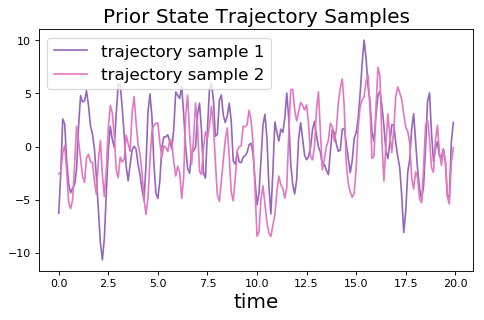

In [11]:
dC_times_inv_C,inv_C = kernel_function(time_points.for_estimation,kernel.param)

## Rewrite ODE's as Linear Combination in Parameters

Since, according to the mass action dynamics (equation 2), the ODEs are linear in the parameters  we can rewrite the ODEs in equation (2) as a linear combination in the parameters:
    
\begin{align}
\mathbf{B}_{\boldsymbol\theta} \boldsymbol\theta + \mathbf{b}_{\boldsymbol\theta} \stackrel{!}{=} \mathbf{f}(\mathbf{X},\boldsymbol\theta),
\label{eqn:lin_comb_param}
\end{align}

where matrices $\mathbf{B}_{\boldsymbol\theta}$ and $\mathbf{b}_{\boldsymbol\theta}$ are defined such that the ODEs $\mathbf{f}(\mathbf{X},\boldsymbol\theta)$ are expressed as a linear combination in $\boldsymbol\theta$.

In [12]:
locally_linear_odes.ode_param.B,locally_linear_odes.ode_param.b = rewrite_odes_as_linear_combination_in_parameters(odes,symbols.state,symbols.param)

## Posterior over ODE Parameters

Inserting \ref{eqn:lin_comb_param} into \ref{eqn:equating_derivative_eqns} and solving for $\boldsymbol\theta$ yields:

\begin{align}
&\boldsymbol\theta = \mathbf{B}_{\boldsymbol\theta}^+ \left( {'\mathbf{C}_{\boldsymbol\phi}} \mathbf{C}_{\boldsymbol\phi}^{-1} \mathbf{X} - \mathbf{b}_{\boldsymbol\theta} + \boldsymbol\epsilon_0 \right),
\end{align}

where $\mathbf{B}_{\boldsymbol\theta}^+$ denotes the pseudo-inverse of $\mathbf{B}_{\boldsymbol\theta}$. Since 
$\mathbf{C}_{\boldsymbol\phi}$ is block diagonal we can rewrite the expression above as:

\begin{align}
\boldsymbol\theta &= \left(\mathbf{B}_{\boldsymbol\theta}^T \mathbf{B}_{\boldsymbol\theta} \right)^{-1} \mathbf{B}_{\boldsymbol\theta}^T \left( \sum_k {'\mathbf{C}_{\boldsymbol\phi_k}} \mathbf{C}_{\boldsymbol\phi_k}^{-1} \mathbf{X}_k - \mathbf{b}_{\boldsymbol\theta_k} + \boldsymbol\epsilon_0^{(k)} \right) \\
&= \left(\mathbf{B}_{\boldsymbol\theta}^T \mathbf{B}_{\boldsymbol\theta} \right)^{-1} \left( \sum_k \mathbf{B}_{\boldsymbol\theta_k}^T {'\mathbf{C}_{\boldsymbol\phi_k}} \mathbf{C}_{\boldsymbol\phi_k}^{-1} \mathbf{X}_k - \mathbf{b}_{\boldsymbol\theta_k} + \boldsymbol\epsilon_0^{(k)} \right)
\end{align}

where we substitute the Moore-Penrose inverse for the pseudo inverse (i.e. $\mathbf{B}_{\boldsymbol\theta}^+ := \left(\mathbf{B}_{\boldsymbol\theta}^T \mathbf{B}_{\boldsymbol\theta} \right)^{-1} \mathbf{B}_{\boldsymbol\theta}^T$). 

We can therefore derive the posterior distribution over ODE parameters:
                                                              
\begin{align}
p(\boldsymbol\theta \mid \mathbf{X}, \boldsymbol\phi, \gamma) = \mathcal{N}\left(\boldsymbol\theta ; \left(\mathbf{B}_{\boldsymbol\theta}^T \mathbf{B}_{\boldsymbol\theta} \right)^{-1} ~ \left( \sum_k \mathbf{B}_{\boldsymbol\theta_k} {'\mathbf{C}_{\boldsymbol\phi_k}} \mathbf{C}_{\boldsymbol\phi_k}^{-1} \mathbf{X}_k - \mathbf{b}_{\boldsymbol\theta_k} \right), ~ \mathbf{B}_{\boldsymbol\theta}^+ ~ (\mathbf{A} + \mathbf{I}\gamma) ~ \mathbf{B}_{\boldsymbol\theta}^{+T} \right).
\label{eqn:posterior_over_param}
\end{align}

## Rewrite ODEs as Linear Combination in Individual States

Since, according to the mass action dynamics (equation 2), the ODEs are linear in the individual state  $\mathbf{x}_u$, we can rewrite the ODE $\mathbf{f}_k(\mathbf{X},\boldsymbol\theta)$ as a linear combination in the individual state $\mathbf{x}_u$:

\begin{align}
\mathbf{R}_{uk} \mathbf{x}_u + \mathbf{r}_{uk} \stackrel{!}{=} \mathbf{f}_k(\mathbf{X},\boldsymbol\theta) - {'\mathbf{C}}_{\boldsymbol\phi} \mathbf{C}_{\boldsymbol\phi}^{-1} \mathbf{X}.
\label{eqn:lin_comb_states}
\end{align}

where matrices $\mathbf{R}_{uk}$ and $\mathbf{r}_{uk}$ are defined such that the ODE $\mathbf{f}(\mathbf{X},\boldsymbol\theta)$ is expressed as a linear combination in the individual state $\mathbf{x}_u$.

In [13]:
locally_linear_odes.state.R,locally_linear_odes.state.r = rewrite_odes_as_linear_combination_in_states(odes,symbols.state,symbols.param,simulation.observed_states,opt_settings.clamp_states_to_observation_fit)

## Posterior over Individual States

Given the linear combination of the ODEs w.r.t. an individual state, we define the matrices $\mathbf{B}_u$ and $\mathbf{b}_u$ such that the expression $\mathbf{f}(\mathbf{X},\boldsymbol\theta) - {'\mathbf{C}}_{\boldsymbol\phi}\mathbf{C}_{\boldsymbol\phi}^{-1} \mathbf{X}$ is rewritten as a linear combination in an individual state $\mathbf{x}_u$:

\begin{align}
\mathbf{B}_{u} \mathbf{x}_u + \mathbf{b}_{u} \stackrel{!}{=}\mathbf{f}(\mathbf{X},\boldsymbol\theta) - {'\mathbf{C}}_{\boldsymbol\phi}\mathbf{C}_{\boldsymbol\phi}^{-1} \mathbf{X} 
\end{align}

Inserting \ref{eqn:lin_comb_states} into \ref{eqn:equating_derivative_eqns} and solving for $\mathbf{x}_u$ yields:

\begin{align}
\mathbf{x}_u = \mathbf{B}_{u}^+ \left( \boldsymbol\epsilon_0 -\mathbf{b}_{u} \right),
\end{align}

where $\mathbf{B}_{u}^+$ denotes the pseudo-inverse of $\mathbf{B}_{u}$. Since $\mathbf{C}_{\boldsymbol\phi}$ is block diagonal we can rewrite the expression above as:

\begin{align}
\mathbf{x}_u &= \left( \mathbf{B}_{u} \mathbf{B}_{u}^T \right)^{-1}\mathbf{B}_{u}^T \sum_k \left(\boldsymbol{\epsilon}_0^{(k)} -\mathbf{b}_{uk} \right)\\ 
&= \left( \mathbf{B}_{u} \mathbf{B}_{u}^T \right)^{-1} \sum_k\mathbf{B}_{uk}^T \left(\boldsymbol{\epsilon}_0^{(k)} -\mathbf{b}_{uk} \right),
\end{align}

where we subsitute the Moore-Penrose inverse for the pseudo-inverse (i.e. $\mathbf{B}_{\boldsymbol\theta}^+ := \left( \mathbf{B}_{\boldsymbol\theta}^T \mathbf{B}_{\boldsymbol\theta}\right)^{-1} \mathbf{B}_{\boldsymbol\theta}^T$ ).

We can therefore derive the posterior distribution over an individual state $\mathbf{x}_u$:

\begin{align}
p(\mathbf{x}_u \mid \mathbf{X}_{-u}, \boldsymbol\phi, \gamma)= \mathcal{N}\left(\mathbf{x}_u ; \left( \mathbf{B}_{u} \mathbf{B}_{u}^T\right)^{-1} \left( - \sum_k \mathbf{B}_{uk}^T \mathbf{b}_{uk} \right),~\mathbf{B}_{u}^{+} ~ (\mathbf{A} + \mathbf{I}\gamma) ~ \mathbf{B}_u^{+T}\right)
\end{align}

with $\mathbf{X}_{-u}$ denoting the set of all states except state $\mathbf{x}_u$.


## Mean-field Variational Inference

To infer the parameters $\boldsymbol\theta$, we want to find the maximum a posteriori estimate (MAP):

\begin{align}
\boldsymbol\theta^\star :&=\mathrm{arg}\max_{\boldsymbol\theta} ~ \ln p(\boldsymbol\theta \mid \mathbf{Y},\boldsymbol\phi,\gamma, \boldsymbol\sigma) \nonumber \\
&= \mathrm{arg}\max_{\boldsymbol\theta} ~ \ln \int  p(\boldsymbol\theta,\mathbf{X} \mid \mathbf{Y},\boldsymbol\phi,\gamma,\boldsymbol\sigma) ~ d\mathbf{X} \nonumber \\
&= \mathrm{arg}\max_{\boldsymbol\theta} ~ \ln \int  \underbrace{p(\boldsymbol\theta \mid \mathbf{X},\boldsymbol\phi,\gamma)}_{\textrm{ODE-informed}} ~ \underbrace{p(\mathbf{X} \mid \mathbf{Y}, \boldsymbol\phi, \boldsymbol\sigma)}_{\textrm{data-informed}} ~ d\mathbf{X}.
\label{eq:map_param}
\end{align}

However, the integral above is intractable due to the strong couplings induced by the nonlinear ODEs $\mathbf{f}$ which appear in the term $p(\boldsymbol\theta \mid \mathbf{X},\boldsymbol\phi,\gamma)$. 

We use mean-field variational inference to establish variational lower bounds that are analytically tractable by decoupling state variables from the ODE parameters as well as decoupling the state variables from each other. We first note that, since the ODEs described by \ref{eqn:ode_spec} are locally linear, both conditional distributions $p(\boldsymbol\theta \mid \mathbf{X},\mathbf{Y},\boldsymbol\phi,\gamma,\boldsymbol\sigma)$ and $p(\mathbf{x}_u \mid \boldsymbol\theta, \mathbf{X}_{-u},\mathbf{Y},\boldsymbol\phi,\gamma,\boldsymbol\sigma)$ are analytically tractable and Gaussian distributed as mentioned previously in section \ref{sec:variational_inference_for_gradient_matching}. 

The decoupling is induced by designing a variational distribution $Q(\boldsymbol\theta,\mathbf{X})$ which is restricted to the family of factorial distributions:

\begin{align}
\mathcal{Q} := \bigg{\{} Q : Q(\boldsymbol\theta,\mathbf{X}) = q(\boldsymbol\theta) \prod_u q(\mathbf{x}_u) \bigg{\}}.
\label{eqn:proxy_family}
\end{align}

The particular form of $q(\boldsymbol\theta)$ and $q(\mathbf{x}_u)$ are designed to be Gaussian distributed which places them in the same family as the true full conditional distributions. To find the optimal factorial distribution we minimize the Kullback-Leibler divergence between the variational and the true posterior distribution:

\begin{align}
\hat{Q} :&= \mathrm{arg}\min_{Q(\boldsymbol\theta,\mathbf{X}) \in \mathcal{Q}} \mathrm{KL} \left[ Q(\boldsymbol\theta,\mathbf{X}) ~ \big{|}\big{|} ~ p(\boldsymbol\theta,\mathbf{X} \mid \mathbf{Y},\boldsymbol\phi, \gamma,\boldsymbol\sigma) \right],
\label{eqn:proxy_objective}
\end{align}

where $\hat{Q}$ is the proxy distribution. The proxy distribution that minimizes the KL-divergence \ref{eqn:proxy_objective} depends on the true full conditionals and is given by:

\begin{align}
&\hat{q}(\boldsymbol\theta) \propto \exp \left( ~  \mathbb{E}_{Q_{-\boldsymbol\theta}} \ln p(\boldsymbol\theta \mid \mathbf{X},\mathbf{Y},\boldsymbol\phi,\gamma,\boldsymbol\sigma) ~ \right) \nonumber \\
&\hat{q}(\mathbf{x}_u) \propto \exp\left( ~ \mathbb{E}_{Q_{-u}} \ln p(\mathbf{x}_u \mid \boldsymbol\theta, \mathbf{X}_{-u},\mathbf{Y},\boldsymbol\phi,\gamma,\boldsymbol\sigma) ~ \right).
\label{eqn:proxies}
\end{align}

with $Q_{-\boldsymbol\theta} := \prod_u q(\mathbf{x}_u)$ and $Q_{-u} := q(\boldsymbol\theta) \prod_{l\neq u} q(\mathbf{x}_l)$. Further expanding the optimal proxy distribution in \ref{eqn:proxies} for $\boldsymbol\theta$ yields:

\begin{align}
\hat{q}(\boldsymbol\theta) &\stackrel{(a)}{\propto} \exp \left( ~  \mathbb{E}_{Q_{-\boldsymbol\theta}} \ln p(\boldsymbol\theta \mid \mathbf{X},\mathbf{Y},\boldsymbol\phi,\gamma,\boldsymbol\sigma) ~ \right)
 \nonumber \\
 &\stackrel{(b)}{\propto} \exp \left( ~  \mathbb{E}_{Q_{-\boldsymbol\theta}} \ln \mathcal{N}\left(\boldsymbol\theta ; \mathbf{B}_{\boldsymbol\theta}^+ ~ \left( {'\mathbf{C}_{\boldsymbol\phi}} \mathbf{C}_{\boldsymbol\phi}^{-1} \mathbf{X} - \mathbf{b}_{\boldsymbol\theta} \right), ~ \mathbf{B}_{\boldsymbol\theta}^+ ~ (\mathbf{A} + \mathbf{I}\gamma) ~ \mathbf{B}_{\boldsymbol\theta}^{+T} \right) ~ \right),
\end{align}

which can be normalized analytically due to its exponential quadratic form. In (a) we recall that the ODE parameters depend only indirectly on the observations $\mathbf{Y}$ through the states $\mathbf{X}$ and in (b) we substitute $p(\boldsymbol\theta \mid \mathbf{X},\boldsymbol\phi,\gamma)$ by its density given in \ref{eqn:posterior_over_param}.

Similarly, we expand the proxy over the individual state $\mathbf{x}_u$:

\begin{align}
\hat{q}(\mathbf{x}_u) &\stackrel{(a)}{\propto} \exp\left( ~ \mathbb{E}_{Q_{-u}} \ln \left( p(\mathbf{x}_u \mid \boldsymbol\theta, \mathbf{X}_{-u},\boldsymbol\phi,\boldsymbol\gamma) p(\mathbf{x}_u \mid\mathbf{Y},\boldsymbol\phi,\boldsymbol\sigma) ~ \right) \right) \nonumber  \\
&\stackrel{(b)}{\propto} \exp\big( ~ \mathbb{E}_{Q_{-u}} \ln \mathcal{N}\left(\mathbf{x}_u ; -\mathbf{B}_{u}^+ \mathbf{b}_u, ~\mathbf{B}_u^{+} ~ (\mathbf{A} + \mathbf{I}\gamma) ~ \mathbf{B}_u^{+T} \right) \nonumber \\
&\qquad \qquad \qquad + \mathbb{E}_{Q_{-u}}  \ln \mathcal{N}\left(\mathbf{x}_u ; \boldsymbol\mu_u(\mathbf{Y}), \boldsymbol\Sigma_u \right) \big),
\end{align}

## Initialization of State Trajectories

We initialize the states by fitting the observations of state trajectories using classical GP regression. The data-informed distribution $p(\mathbf{X} \mid \mathbf{Y}, \boldsymbol\phi,\boldsymbol\sigma)$ in equation (9) can be determined analytically using Gaussian process regression with the GP prior $p(\mathbf{X} \mid \boldsymbol\phi) = \prod_k \mathcal{N}(\mathbf{x}_k ;\mathbf{0},\mathbf{C}_{\boldsymbol\phi_k})$:

\begin{align}
p(\mathbf{X} \mid \mathbf{Y}, \boldsymbol\phi,\gamma) = \prod_k\mathcal{N}(\mathbf{x}_k;\boldsymbol\mu_k(\mathbf{y}_k),\boldsymbol\Sigma_k),
\end{align}

where $\boldsymbol\mu_k(\mathbf{y}_k) := \sigma_k^{-2} \left(\mathbf{\sigma}_k^{-2}\mathbf{I} + \mathbf{C}_{\boldsymbol\phi_k}^{-1} \right)^{-1} \mathbf{y}_k$ and $\boldsymbol\Sigma_k ^{-1}:=\mathbf{\sigma}_k^{-2} \mathbf{I} +\mathbf{C}_{\mathbf{\phi}_k}^{-1}$.

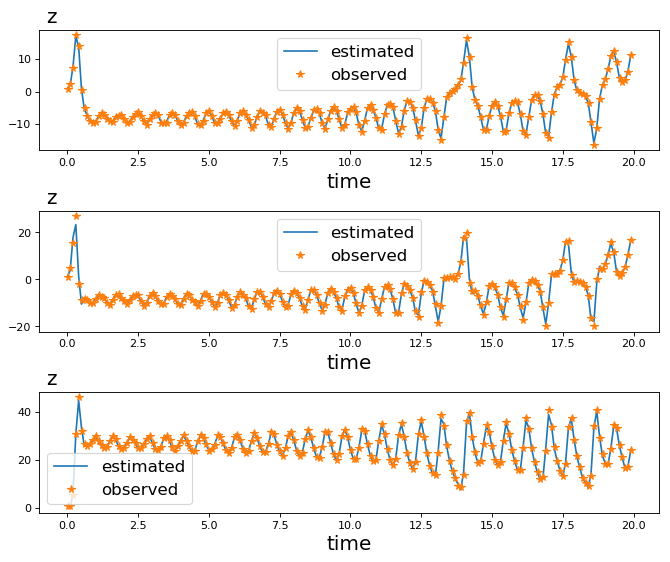

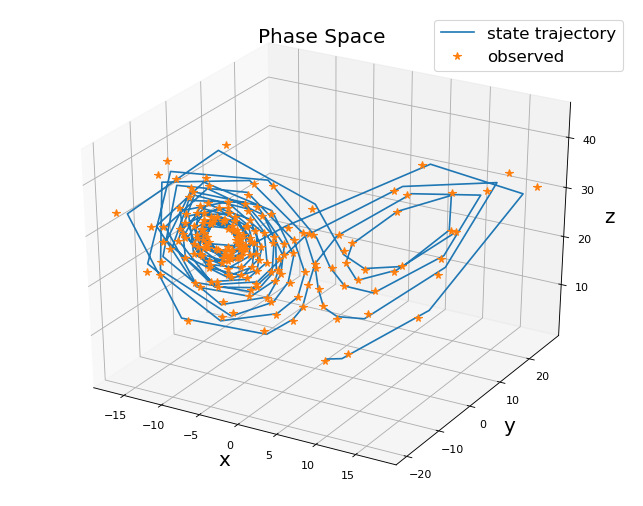

In [14]:
GP_post_mean,GP_post_inv_cov = fitting_state_observations(simulation.observations,inv_C,symbols.state,simulation.observed_states,obs_to_state_relations,simulation.obs_variance,time_points.for_estimation,time_points.observed)
proxy.state = GP_post_mean

Form block-diagonal matrix out of $\mathbf{C}_{\boldsymbol\phi_k}^{-1}$

## Variational Coordinate Ascent

We minimize the KL-divergence in equation (10) by variational coordinate descent (where each step is analytically tractable) by iterating between determining the proxy for the distribution over ODE parameters $\hat{q}(\boldsymbol\theta)$ and the proxies for the distribution over individual states $\hat{q}(\mathbf{x}_u)$.

#### Proxy for ODE Parameters

Expanding the proxy distribution in equation (11) for $\boldsymbol\theta$ yields:

\begin{align}
\hat{q}(\boldsymbol\theta) &\propto ~ \exp \left( ~E_{Q_{-\boldsymbol\theta}}     \ln p(\boldsymbol\theta \mid \mathbf{X},\mathbf{Y},\boldsymbol\phi,\gamma,\mathbf\sigma)
~     \right) \\ 
&= \exp \left( ~E_{Q_{-\boldsymbol\theta}} \ln \mathcal{N}\left(\boldsymbol\theta
; \left(    \mathbf{B}_{\boldsymbol\theta}^T \mathbf{B}_{\boldsymbol\theta} \right)^{-1}
\left( \sum_k    \mathbf{B}_{\boldsymbol\theta_k}^T ~ \left( {'\mathbf{C}_{\boldsymbol\phi_k}}    \mathbf{C}_{\boldsymbol\phi_k}^{-1} \mathbf{X}_k - \mathbf{b}_{\boldsymbol\theta
k} \right)    \right), ~ \mathbf{B}_{\boldsymbol\theta}^+ ~ (\mathbf{A} + \mathbf{I}\gamma)
~    \mathbf{B}_{\boldsymbol\theta}^{+T} \right) ~\right),
\end{align}
    
where we substitute $p(\boldsymbol\theta \mid \mathbf{X},\boldsymbol\phi,\gamma)$ with its density given in equation (6).


#### Proxy for Individual State

Expanding the proxy distribution in equation (12) over the individual state $\mathbf{x}_u$:
    
    
\begin{align}
\hat{q}(\mathbf{x}_u) &\stackrel{(a)}{\propto} \exp \left(~ E_{Q_{-u}}  \ln ( p(\mathbf{x}_u \mid \boldsymbol\theta, \mathbf{X}_{-u},\boldsymbol\phi,\gamma) p(\mathbf{x}_u  \mid\mathbf{Y},\boldsymbol\phi,\mathbf\sigma) ) ~ \right)\\ 
&\stackrel{(b)}{=} \exp\big( ~ E_{Q_{-u}} \ln     \mathcal{N}\left(\mathbf{x}_u
; -\mathbf{B}_{u}^+ \mathbf{b}_u,     ~\mathbf{B}_u^{+} ~ (\mathbf{A} + \mathbf{I}\gamma)
~     \mathbf{B}_u^{+T} \right) + E_{Q_{-u}} \ln    \mathcal{N}\left(\mathbf{x}_u
; \boldsymbol\mu_u(\mathbf{Y}), \boldsymbol\Sigma_u    \right) \big)\\
&= \exp\big(~ E_{Q_{-u}} \ln                \mathcal{N}\left(\mathbf{x}_u ; -\mathbf{B}_{u}^+
\mathbf{b}_u,~\mathbf{B}_u^{+} ~ (\mathbf{A} + \mathbf{I}\gamma)\mathbf{B}_u^{+T} \right) + E_{Q_{-u}} \ln                \mathcal{N}\left(\mathbf{x}_u; \boldsymbol\mu_u(\mathbf{Y}), \boldsymbol\Sigma_u \right) \big).
\end{align}
    
In (a) we decompose the full conditional nto an ODE-informed distribution and a data-informed distribution and in (b) we substitute the ODE-informed
distribution $p(\mathbf{x}_u \mid \boldsymbol\theta, \mathbf{X}_{-u},\boldsymbol\phi,\gamma)$
with its density given by equation (8).


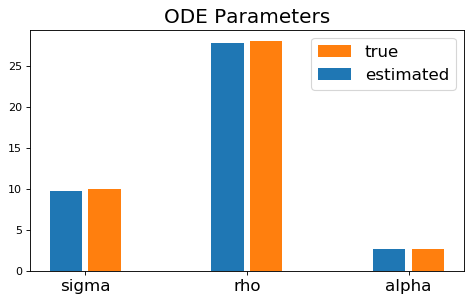

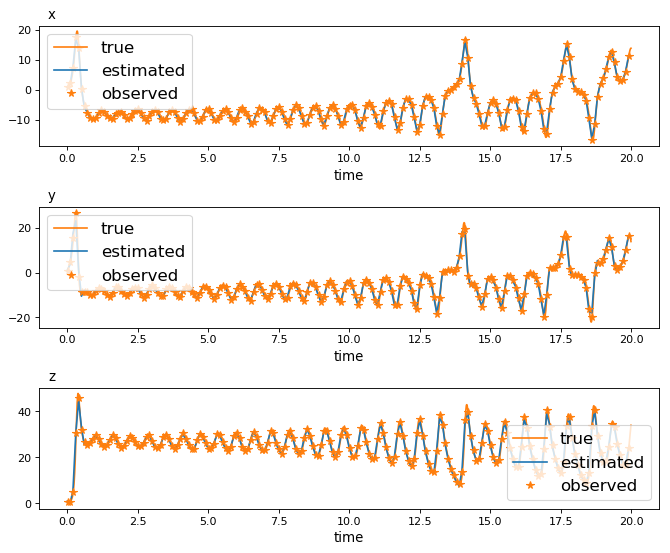

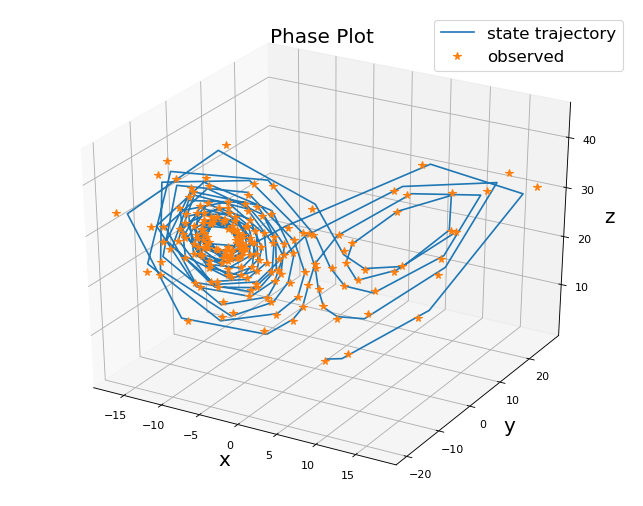

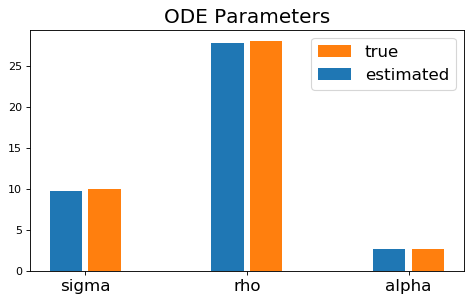

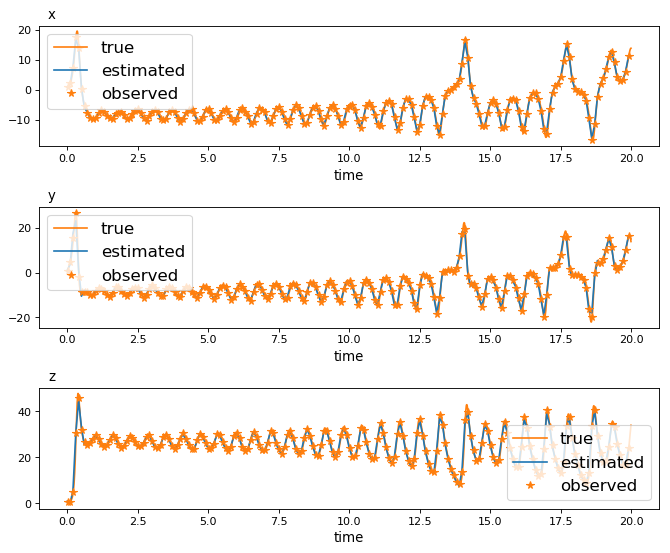

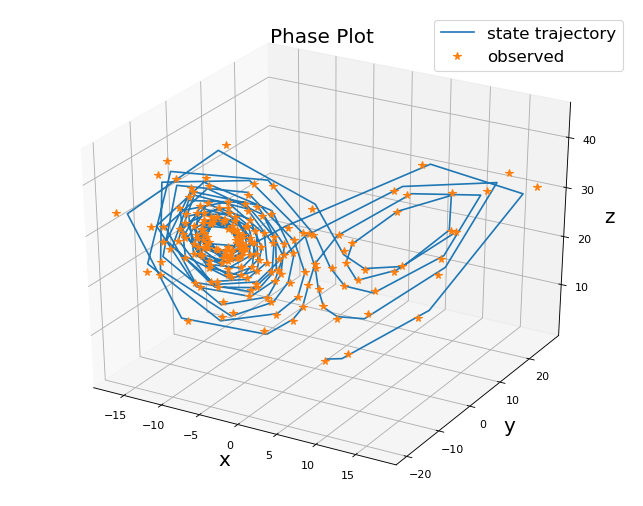

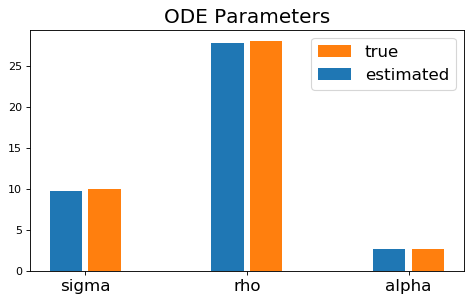

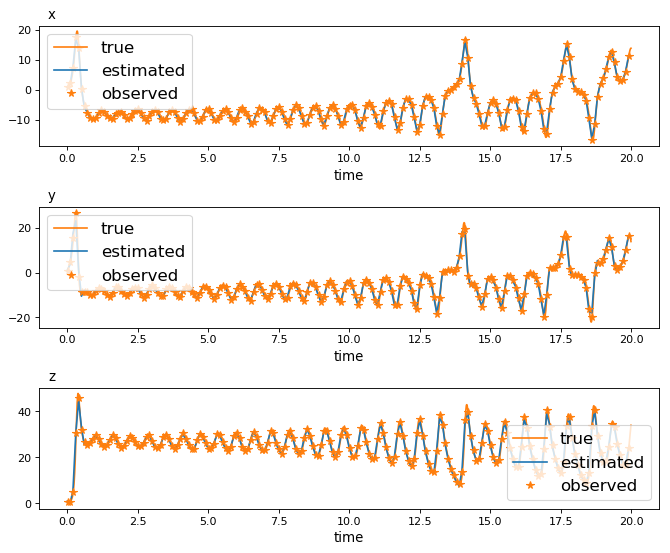

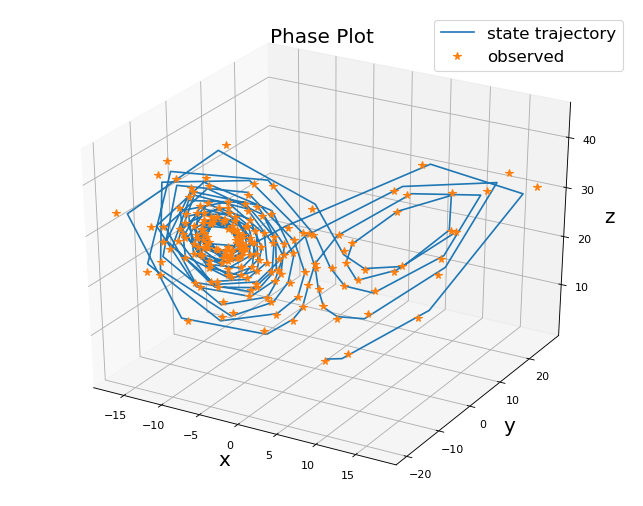

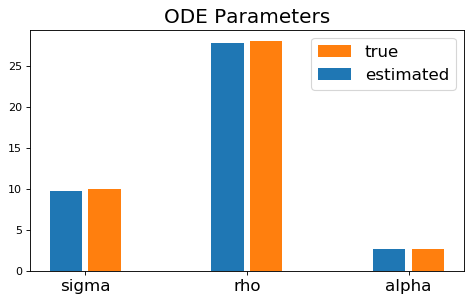

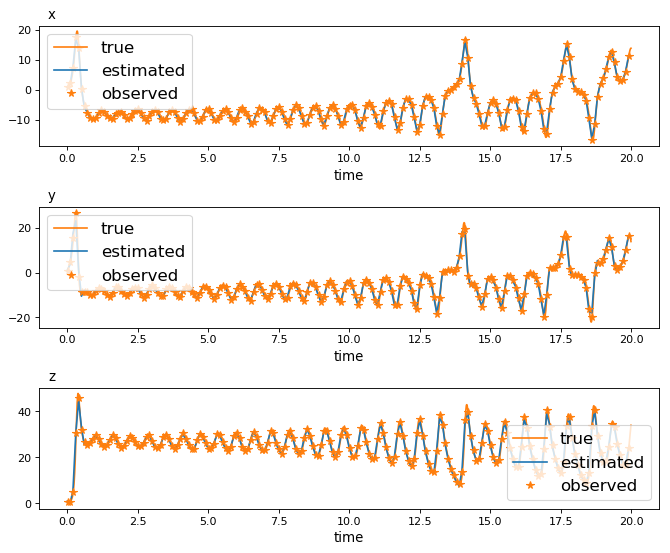

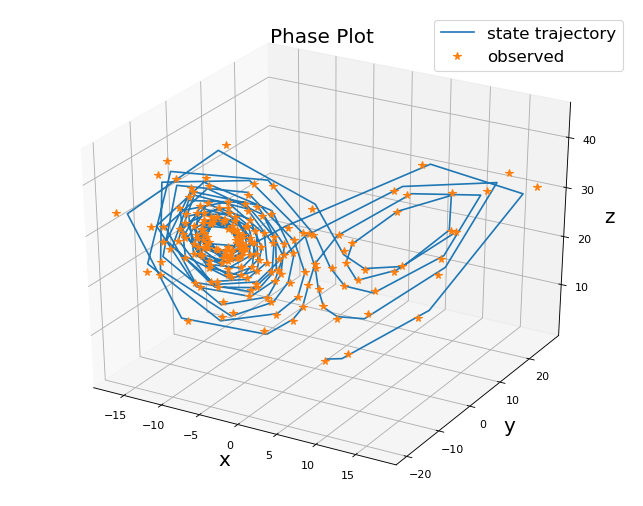

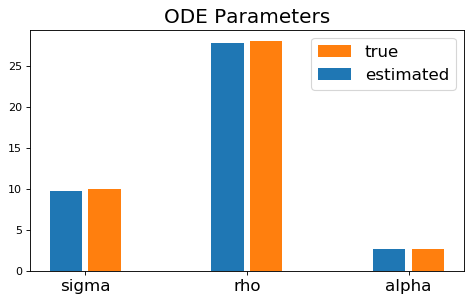

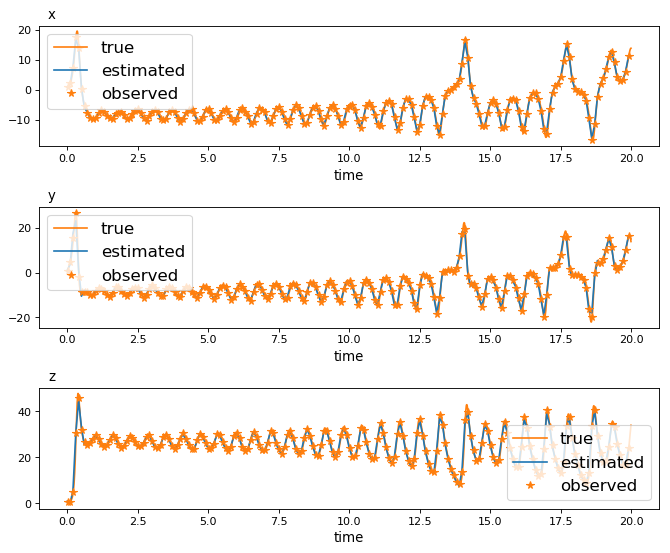

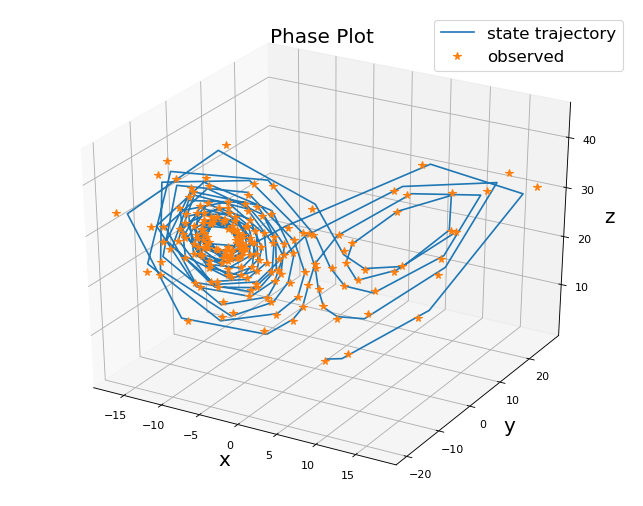

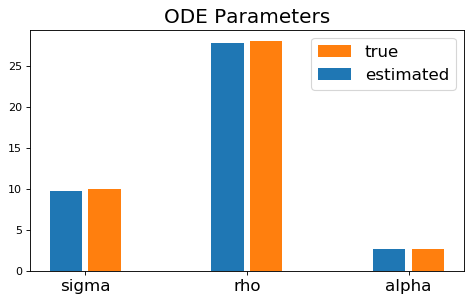

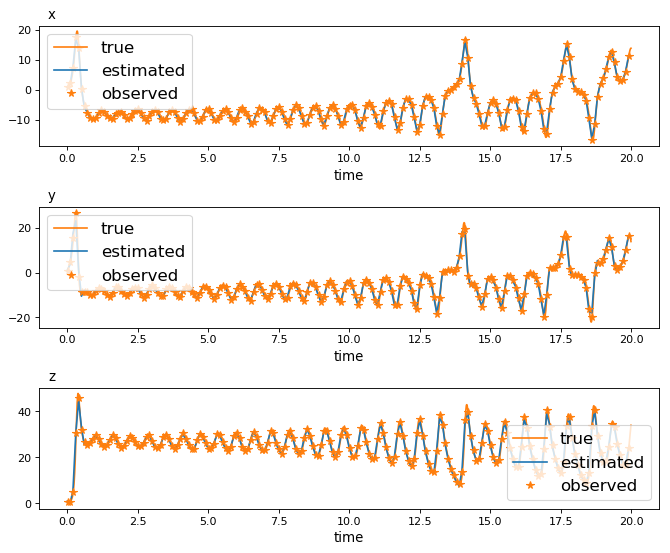

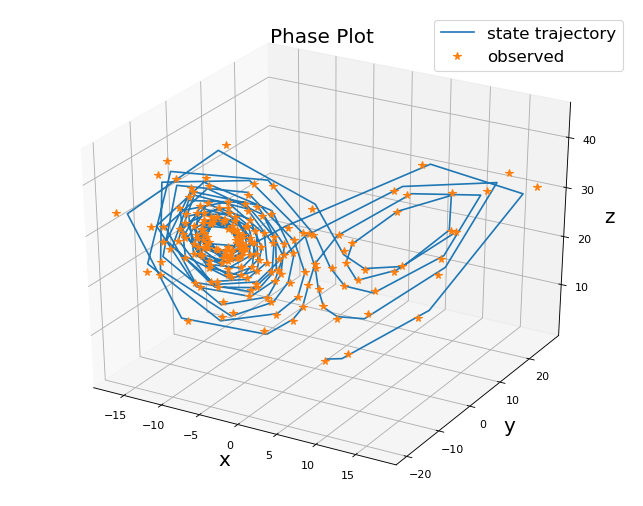

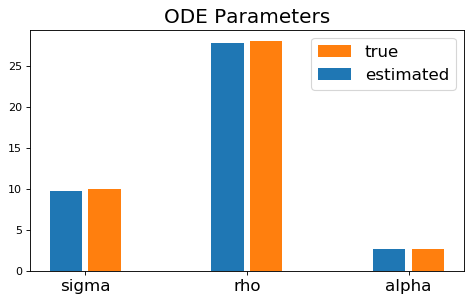

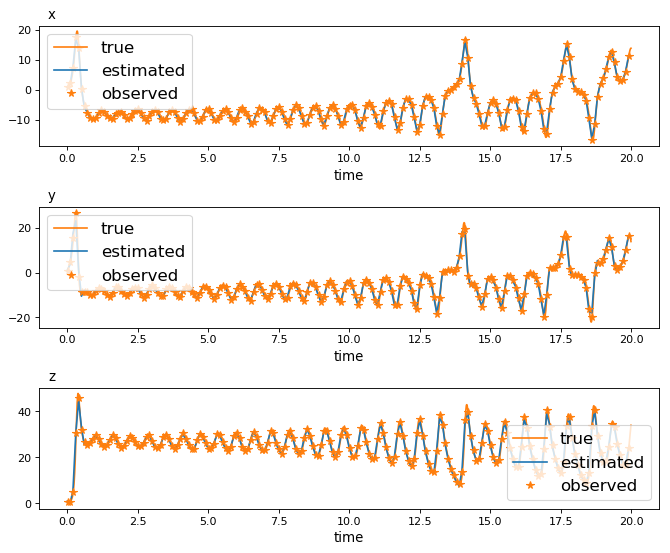

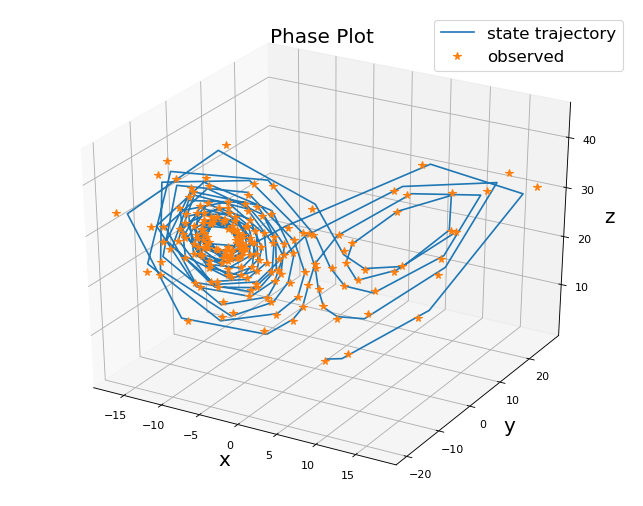

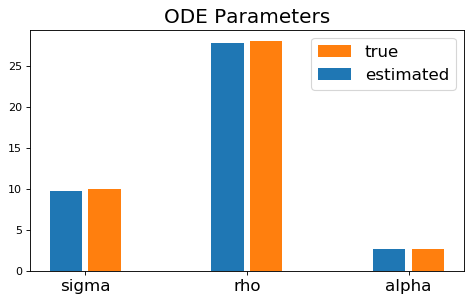

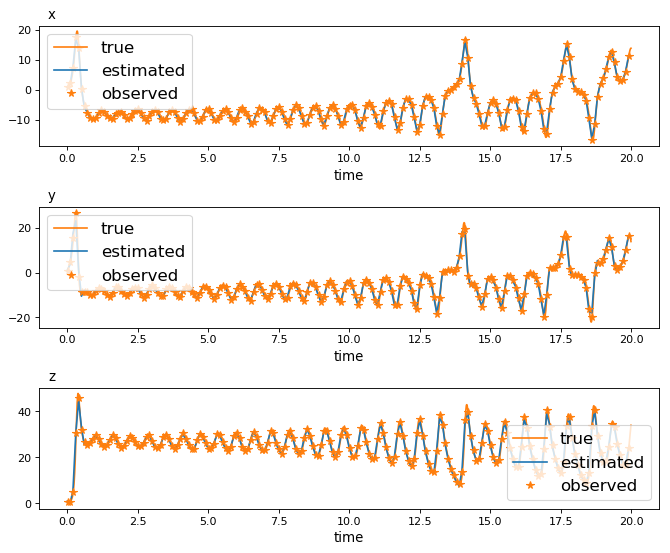

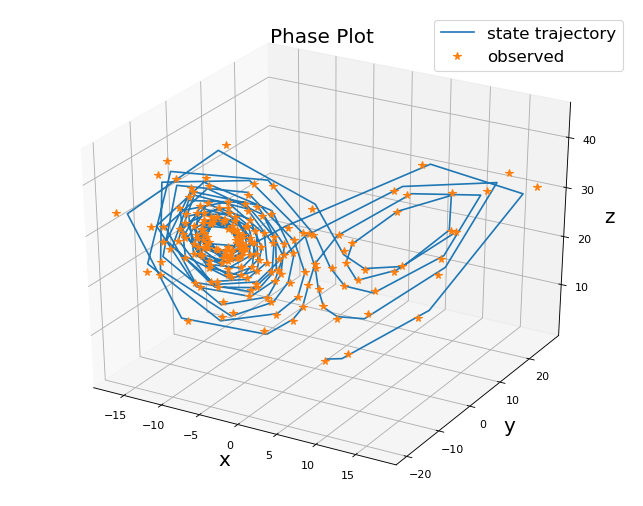

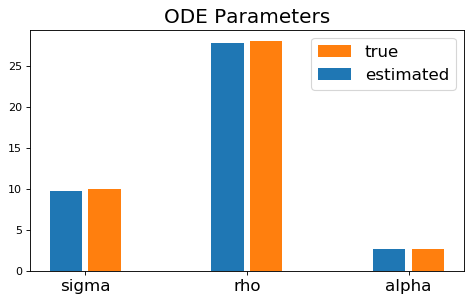

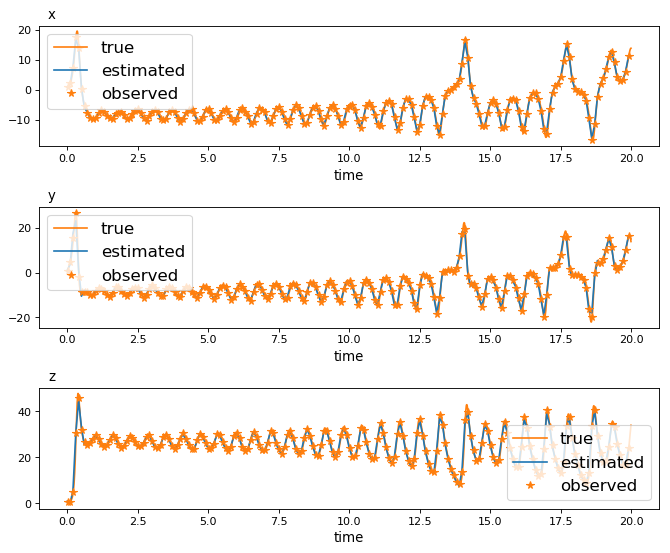

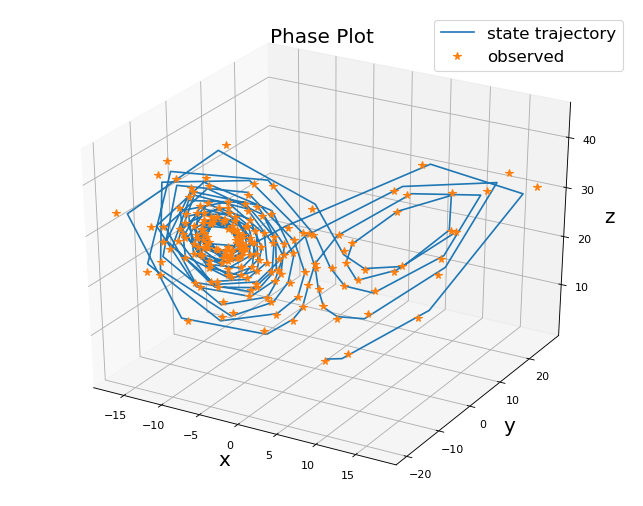

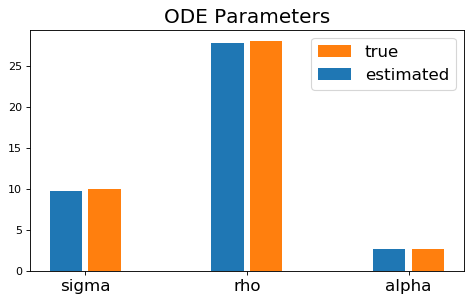

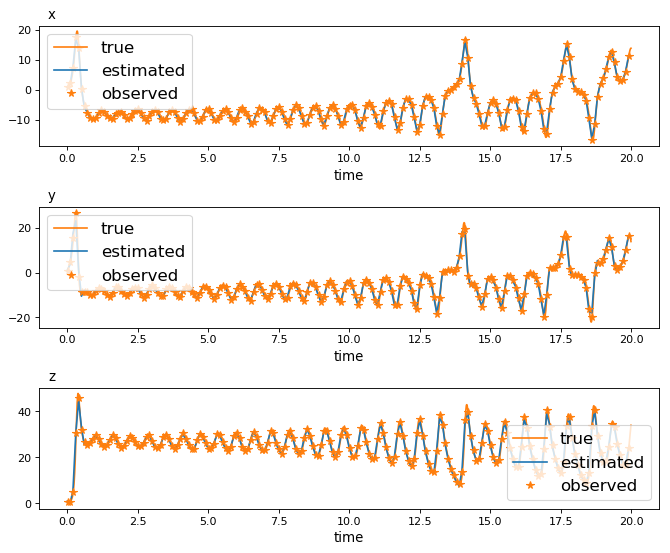

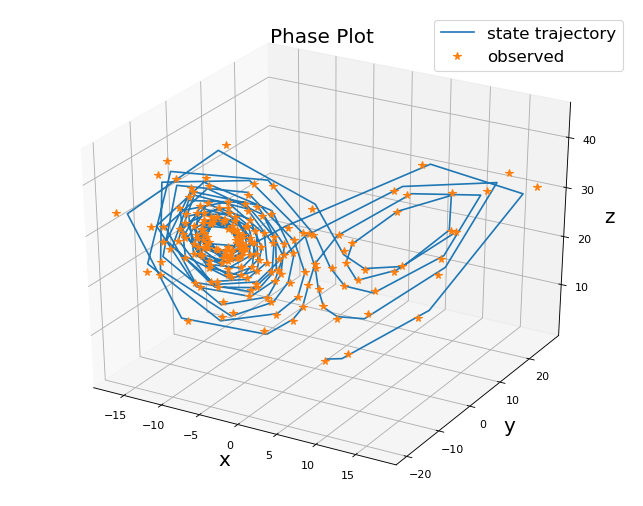

In [15]:
for i in range(opt_settings.number_of_ascending_steps):
    proxy.param = proxy_for_ode_parameters(proxy.state,locally_linear_odes,dC_times_inv_C,symbols.param,simulation.ode_param)
    proxy.state = proxy_for_ind_states(proxy.state,proxy.param,locally_linear_odes,dC_times_inv_C,symbols.state,simulation.observed_states,state_couplings,time_points,simulation,GP_post_mean,GP_post_inv_cov,opt_settings.clamp_states_to_observation_fit,simulation.observations)

## Numerical Integration with Estimated ODE Parameters

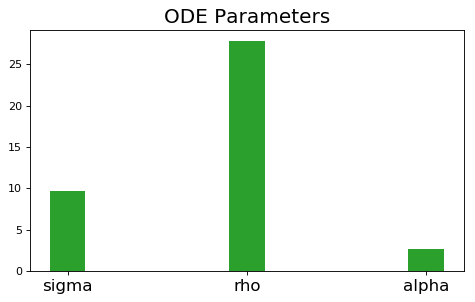

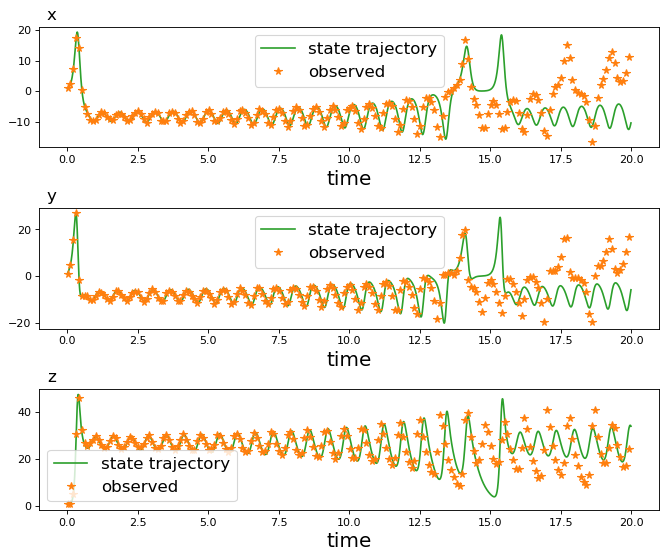

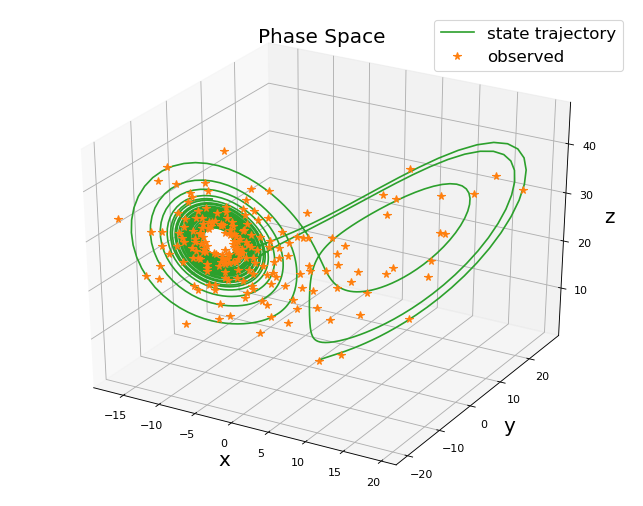

In [16]:
simulation_with_est_param = simulation
simulation_with_est_param.ode_param = proxy.param
simulation.state, simulation.observations, time_points.observed, obs_to_state_relations = simulate_state_dynamics(simulation_with_est_param,time_points,symbols.state,symbols.param,odes,2,simulation.observations,time_points.observed)